### Importing all the pacakges

In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision import datasets

import numpy as np
import random
import matplotlib.pyplot as plt

### Loading the data and then transforming to tensors

In [ ]:
mnist_train = datasets.MNIST(root='./data', download=True, train=True, transform=T.ToTensor())
mnist_test = datasets.MNIST(root='./data', download=False, train=False, transform=T.ToTensor())

In [ ]:
train_set = torchvision.datasets.MNIST(
    root='./MNISTdata'
    ,train=True #Training Data of 60k Images
    ,download=True
)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(20)

### Generation of the Random Number and also the MNIST dataset.

In [ ]:
class MNISTRandGen(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]

        rand_num = random.randint(0, 9)

        rand_num_tensor = F.one_hot(torch.tensor(rand_num), num_classes=10)
        sum_label = label + rand_num

        return image, rand_num_tensor, label, rand_num,sum_label

In [ ]:
train_ds = MNISTRandGen(mnist_train)
test_ds = MNISTRandGen(mnist_test)

### Lets visualize the data we generated

one hot representation of the random number  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
random number  6
Label of the image  9
total  15


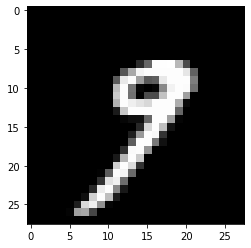

In [ ]:
image1 = train_ds[33]
plt.imshow(image1[0][0].squeeze(), cmap='gray')
print("one hot representation of the random number ",image1[1])
print("random number " ,image1[3])
print("Label of the image ",image1[2])
print("total ",image1[4])


### Lets load the data using Data Loader and lets see some random 30 images and also the shape from the random number generator class

In [ ]:
train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, 64, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
sample = next(iter(train_loader))

In [ ]:
images, rand_nums, labels, sums,total = sample

In [ ]:

images.shape, rand_nums.shape, labels.shape, sums.shape,total.shape

(torch.Size([64, 1, 28, 28]),
 torch.Size([64, 10]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64]))

labels: tensor([2, 2, 5, 0, 1, 4, 4, 4, 5, 2, 2, 1, 2, 0, 9, 7, 9, 2, 7, 9, 1, 2, 2, 7, 7, 0, 4, 8, 5, 2])


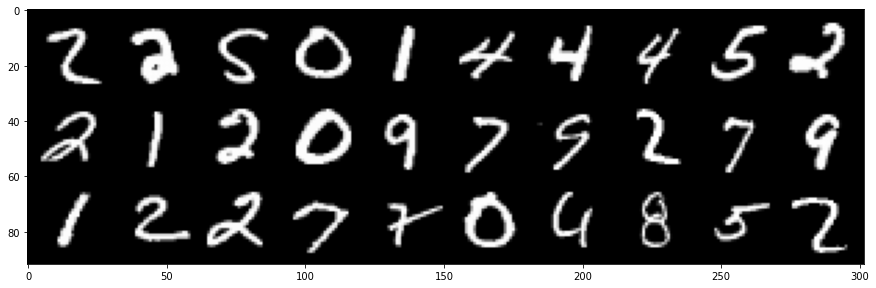

In [ ]:
import numpy as np

grid = torchvision.utils.make_grid(images[:30], nrow=10)
plt.figure(figsize=(15,15))
# Torch Has Channel x Width x Heigth
# Coverting it to Width x Heigth x Channels using Transpose
plt.imshow(np.transpose(grid, (1,2,0))) 
print('labels:', labels[:30])

### Checking which GPU/CPU is running

In [ ]:
def get_default_device():
    """
    Pick GPU if available, else CPU.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

### Creating a Neural Network Class which contains convuluted and fully connected layers

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
      
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # 28x28x1 -> 28x28x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 28x28x1 -> 28x28x32
        self.pool1 = nn.MaxPool2d(2,2) # 28x28x32 -> 14x14x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # 14x14x32 -> 14x14x64
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1) # 14x14x64 -> 14x14x64
        self.pool2 = nn.MaxPool2d(2,2) # 14x14x64 -> 7x7x64
        self.conv5 = nn.Conv2d(64, 128, 3) # 7x7x64 -> 5x5x128
        self.conv6 = nn.Conv2d(128, 256, 3) # 5x5x128 -> 3x3x256
        self.conv7 = nn.Conv2d(256, 10, 3) # 3x3x10 -> 1x1x10

        self.layer1 = nn.Linear(20,19,bias=False)


    def forward(self, x, y):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
#connecting the random number input and also the predicted image input when they have the same size

        y = torch.cat((x,y),dim=1) #Horizontal Stacking. 1x10 and 1x10 -> 1x20


        y = self.layer1(y)
     

        return F.log_softmax(x, dim=1), F.log_softmax(y, dim=1)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random, math

class RandomNumGen(Dataset):
  
    def __init__(self, MNIST_data):
        self.MNIST = MNIST_data
       
    
    def __getitem__(self, index):
        image, label = self.MNIST[index]
        number = random.randint(0,9)
        
        ohv_num = torch.zeros(10)
        ohv_num[number] = 1


        return ((image,ohv_num), (label,number+label))

    def __len__(self):
        return len(self.MNIST)

In [ ]:
train_ds = RandomNumGen(mnist_train)
test_ds = RandomNumGen(mnist_test)

In [ ]:
train_loader = DataLoader(train_ds, 64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, 64, shuffle=False, num_workers=2, pin_memory=True)

### Train and Test functions using NLL loss and summed evaluation

In [ ]:

def train(model, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        img, lab = data[0].to('cuda'), target[0].to('cuda')
        num, tnum = data[1].to('cuda'), target[1].to('cuda')
        optimizer.zero_grad()
        output = model(img, num)
        loss1 = F.nll_loss(output[0], lab)
        loss2 = F.nll_loss(output[1], tnum)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct_img = 0
    correct_num = 0
    with torch.no_grad():
        for data, target in test_loader:
            img, lab = data[0].to('cuda'), target[0].to('cuda')
            num, tnum = data[1].to('cuda'), target[1].to('cuda')
            output = model(img, num)
            loss1 = F.nll_loss(output[0], lab)
            loss2 = F.nll_loss(output[1], tnum)
            loss = loss1 + loss2
            test_loss += loss
            pred1 = output[0].argmax(dim=1, keepdim=True)
            correct_img += pred1.eq(lab.view_as(pred1)).sum().item()
            pred2 = output[1].argmax(dim=1, keepdim=True)
            correct_num += pred2.eq(tnum.view_as(pred2)).sum().item()

        test_loss /= len(test_loader)

        print('\nTest set: Average loss: {:.4f}, Accuracy1: {}/{} ({:.0f}%), Accuracy2: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct_img, len(test_loader.dataset),
        100. * correct_img / len(test_loader.dataset),
        correct_num, len(test_loader.dataset),
        100. * correct_num / len(test_loader.dataset)))

### Model training using 16 epochs

In [ ]:

model = Network().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    train(model, train_loader, optimizer)
    test(model, test_loader)

loss=1.2538264989852905 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.86it/s]



Test set: Average loss: 1.3398, Accuracy1: 9845/10000 (98%), Accuracy2: 4900/10000 (49%)



loss=1.172275424003601 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.53it/s]



Test set: Average loss: 1.2803, Accuracy1: 9863/10000 (99%), Accuracy2: 4984/10000 (50%)



loss=0.7922142744064331 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.54it/s]



Test set: Average loss: 0.8664, Accuracy1: 9910/10000 (99%), Accuracy2: 6701/10000 (67%)



loss=0.8499040007591248 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.20it/s]



Test set: Average loss: 0.9152, Accuracy1: 9913/10000 (99%), Accuracy2: 6711/10000 (67%)



loss=0.8697547316551208 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.02it/s]



Test set: Average loss: 0.8900, Accuracy1: 9911/10000 (99%), Accuracy2: 6658/10000 (67%)



loss=0.6686374545097351 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.96it/s]



Test set: Average loss: 0.6791, Accuracy1: 9921/10000 (99%), Accuracy2: 7942/10000 (79%)



loss=2.170863389968872 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.96it/s]



Test set: Average loss: 0.5579, Accuracy1: 9932/10000 (99%), Accuracy2: 8872/10000 (89%)



loss=0.6816314458847046 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.55it/s]



Test set: Average loss: 0.6242, Accuracy1: 9921/10000 (99%), Accuracy2: 8661/10000 (87%)



loss=0.38011395931243896 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.83it/s]



Test set: Average loss: 0.7262, Accuracy1: 9918/10000 (99%), Accuracy2: 8104/10000 (81%)



loss=0.37112191319465637 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.85it/s]



Test set: Average loss: 0.6148, Accuracy1: 9929/10000 (99%), Accuracy2: 8290/10000 (83%)



loss=0.2961824834346771 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.64it/s]



Test set: Average loss: 0.5272, Accuracy1: 9929/10000 (99%), Accuracy2: 9027/10000 (90%)



loss=0.46351972222328186 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.50it/s]



Test set: Average loss: 0.6365, Accuracy1: 9921/10000 (99%), Accuracy2: 8598/10000 (86%)



loss=0.44882676005363464 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.60it/s]



Test set: Average loss: 0.7144, Accuracy1: 9930/10000 (99%), Accuracy2: 7983/10000 (80%)



loss=0.29906904697418213 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.97it/s]



Test set: Average loss: 0.6271, Accuracy1: 9923/10000 (99%), Accuracy2: 8475/10000 (85%)



loss=0.897777795791626 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 40.00it/s]



Test set: Average loss: 0.7062, Accuracy1: 9926/10000 (99%), Accuracy2: 7999/10000 (80%)



## Evaluation of Network

In [ ]:
inputs, labels = next(iter(test_loader))
img, rando = inputs
lab, sum = labels

output = model(img.to('cuda'), rando.to('cuda'))
pred1 = output[0].argmax(dim=1, keepdim=True)
pred2 = output[1].argmax(dim=1, keepdim=True)

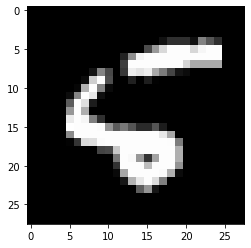

In [ ]:
import matplotlib.pyplot as plt

some_random = random.randint(0,64)

plt.imshow(img[some_random].squeeze(), cmap='gray')

In [ ]:
print('Ground Truth MNIST: ', lab[some_random])
print('Predicted MNIST: ', pred1[some_random])

Ground Truth MNIST:  tensor(5)
Predicted MNIST:  tensor([5], device='cuda:0')


In [ ]:

print('Random Number: ', rando[some_random].argmax(dim=0).item())
print('Ground Truth MNIST: ', lab[some_random])
print('Ground Truth Random Number + MNIST: ', sum[some_random])
print('Predicted Random Number + MNIST: ', pred2[some_random])

Random Number:  8
Ground Truth MNIST:  tensor(5)
Ground Truth Random Number + MNIST:  tensor(13)
Predicted Random Number + MNIST:  tensor([13], device='cuda:0')


In [ ]:

# Create an object of the class Network and transfer it to the GPU
model1 = Network().to(device)
print(" The model layers are: ")
print(model1)

print("\nShape of parameters in each layer is: ")
for name, param in model1.named_parameters():
    print(name, '\t\t', param.shape)

 The model layers are: 
Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 10, kernel_size=(3, 3), stride=(1, 1))
  (layer1): Linear(in_features=20, out_features=19, bias=False)
)

Shape of parameters in each layer is: 
conv1.weight 		 torch.Size([16, 1, 3, 3])
conv1.bias 		 torch.Size([16])
conv2.weight 		 torch.Size([32, 16, 3, 3])
conv2.bias 		 torch.Size([32])
conv3.weight 		 torch.Size([64, 32, 3, 3])
conv3

In [ ]:
!pip3 install graphviz
!pip3 install hiddenlayer

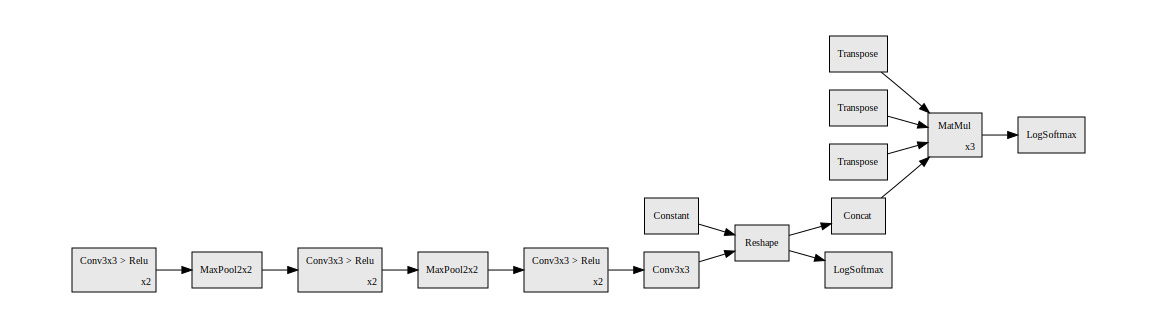

In [ ]:

import hiddenlayer as hl
hl.build_graph(model, (torch.zeros([1, 1, 28, 28]).to('cuda'), torch.zeros(1,10).to('cuda')))

In [ ]:
optimizer.param_groups[0]['params'][0]

Parameter containing:
tensor([[[[-4.6292e-01, -4.8460e-01, -5.4478e-01],
          [ 4.2600e-01,  1.3317e-01, -1.5430e-01],
          [ 3.1888e-01,  3.6262e-01, -3.2004e-01]]],


        [[[-4.3217e-01,  1.4333e-01,  3.0194e-01],
          [-1.7987e-01,  2.5543e-01, -2.6825e-01],
          [-3.4804e-01,  4.4069e-02, -2.5075e-01]]],


        [[[-2.5349e-01, -3.1383e-01, -1.3900e+00],
          [ 1.9165e-01, -1.1502e+00, -6.4352e-01],
          [-6.1007e-02, -2.0055e-01, -1.5822e-01]]],


        [[[-8.4272e-02, -1.2472e-02, -1.5857e-01],
          [-9.4267e-02,  4.5839e-01, -1.7971e-01],
          [-6.5636e-01,  2.9286e-01,  3.0740e-03]]],


        [[[-6.7003e-01, -5.7565e-01, -2.1208e-01],
          [-2.5724e-01, -3.3764e-01, -4.5675e-01],
          [-7.8149e-02, -3.5876e-01, -5.9591e-01]]],


        [[[-3.3756e-01, -2.8329e-01, -4.7580e-01],
          [ 1.1175e-03,  7.1700e-01, -1.5069e-01],
          [-3.3611e-01,  1.5543e-01, -2.7861e-01]]],


        [[[ 5.1265e-01,  1.9066e-02,